In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

In [2]:
#read data from compressed file
book = pd.read_csv('./data/BTC/BTC_Book_0.zip', compression='zip', index_col = 0, parse_dates=True)

#segment into relevant components
bid_prices = book[book.columns[1:151:3]]
bid_sizes = book[book.columns[2:151:3]]
bid_trades = book[book.columns[3:151:3]]

ask_prices = book[book.columns[151::3]]
ask_sizes = book[book.columns[152::3]]
ask_trades = book[book.columns[153::3]]

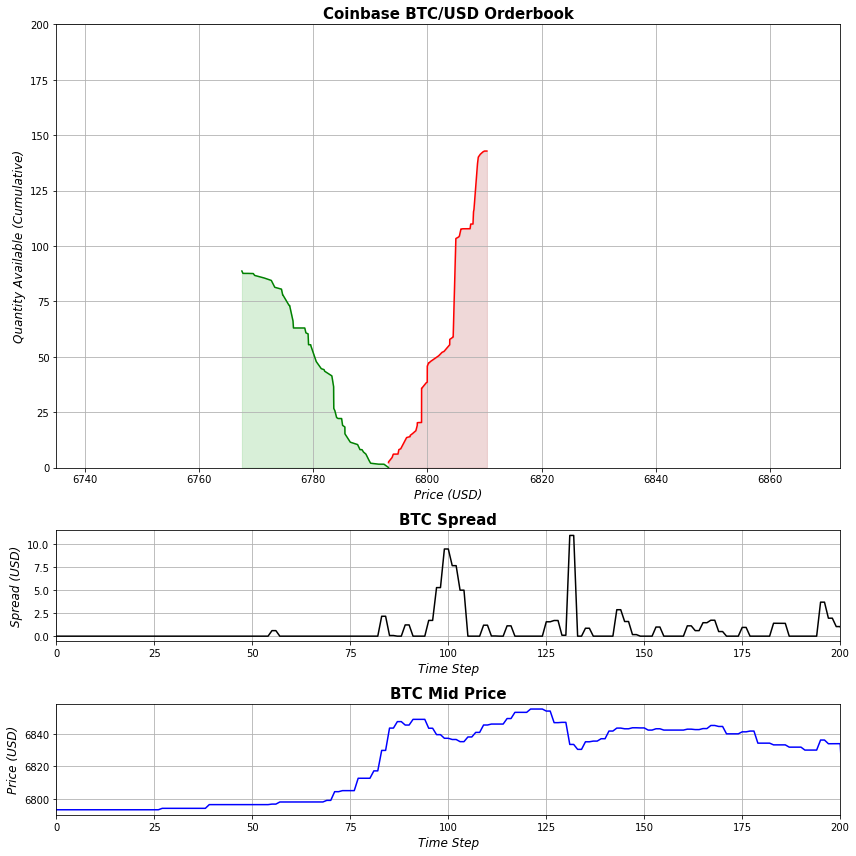

In [3]:
#set global parameters
START = 45400
LENGTH = 200

PRICE_MIN = bid_prices[START:START+LENGTH].values.min()
PRICE_MAX = ask_prices[START:START+LENGTH].values.max()

#plot structure
fig, axs = plt.subplots(3,1, figsize = (12,12), gridspec_kw={'height_ratios': [4, 1, 1]})
fig.set_tight_layout(True)

spread = []
mid_price = []

#format subplot function
def axs_format(ax, title, xlabel, ylabel, xlims = None, ylims = None):
    ax.clear()
    
    if xlims is not None:
        ax.set_xlim(left = xlims[0], right = xlims[1])
    if ylims is not None:
        axs[0].set_ylim(bottom = ylims[0], top = ylims[1])
        
    ax.set_title(title, fontsize = 15, weight = 'bold')
    ax.set_xlabel(xlabel, fontsize = 12, style = 'italic')
    ax.set_ylabel(ylabel, fontsize = 12, style = 'italic')    

#animation step
def animate(i):
    #shift to desired start point
    i+=START
    
    #plot order book cumulative levels
    axs_format(axs[0], 'Coinbase BTC/USD Orderbook', 'Price (USD)', 
               'Quantity Available (Cumulative)', (PRICE_MIN, PRICE_MAX), (0,200))
    axs[0].plot(ask_prices.iloc[i], ask_sizes.iloc[i].cumsum(), color = 'red')
    axs[0].plot(bid_prices.iloc[i], bid_sizes.iloc[i].cumsum(), color = 'green')
    
    #fancy coloring
    l1 = axs[0].fill_between(ask_prices.iloc[i], ask_sizes.iloc[i].cumsum(), color = 'red')
    l2 = axs[0].fill_between(bid_prices.iloc[i], bid_sizes.iloc[i].cumsum(), color = 'green')
    l1.set_facecolors([[.8,.5,.5,.3]])
    l1.set_edgecolors([[.8, .5, .5, .3]])
    l2.set_facecolors([[.5,.8,.5,.3]])
    l2.set_edgecolors([[.5, .8, .5, .3]])
    axs[0].grid('on')
    
    #plot spread
    spread.append(ask_prices.iloc[i][0] - bid_prices.iloc[i][0])
    axs_format(axs[1], 'BTC Spread', 'Time Step', 'Spread (USD)', (0,LENGTH))
    axs[1].plot(spread, color = 'black')
    axs[1].grid('on')
    
    #plot Midprice
    mid_price.append((ask_prices.iloc[i][0] + bid_prices.iloc[i][0])/2)
    axs_format(axs[2], 'BTC Mid Price', 'Time Step', 'Price (USD)', (0,LENGTH))
    axs[2].plot(mid_price, color = 'blue')  
    axs[2].grid('on')
    

#execute animation
anim = FuncAnimation(fig, animate, frames=LENGTH)
anim.save('./figures/BTC_Order_Book.gif', writer='imagemagick')

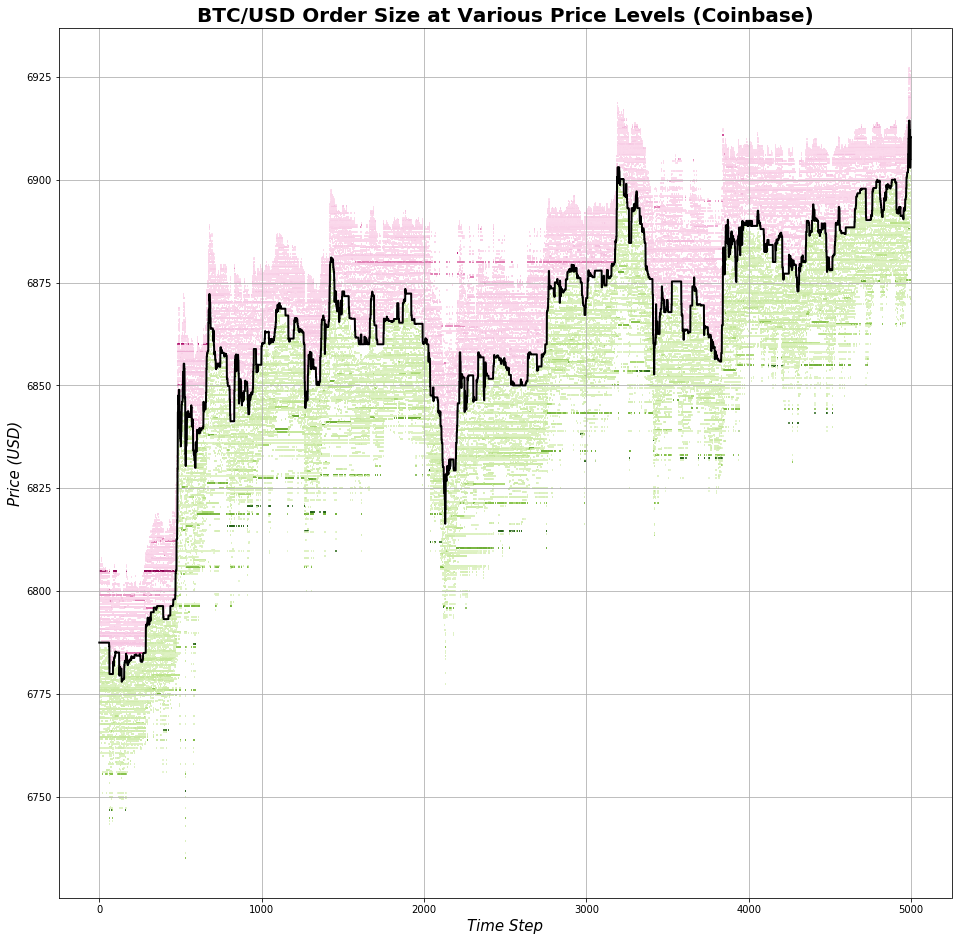

In [4]:
#set global sequence parameters
START = 45000
LENGTH = 5000

#compute midprice of book
mid_price = ((bid_prices[START:START+LENGTH]['Bid_1_Price'] + 
              ask_prices[START:START+LENGTH]['Ask_1_Price'])/2).values

#use fixed index due to matplotlib time index bugs
x = np.arange(0,LENGTH,1)
y = np.concatenate((bid_prices[START:START+LENGTH].values, ask_prices[START:START+LENGTH].values), axis=1)
#form plottable tuples
plot_x = np.repeat(x, y.shape[1])
plot_y = y.flatten()

#rescale bid and ask sizes - add a buffer around 0 so that color difference is more pronounced
ptr = bid_sizes[START:START+LENGTH]
scaled_bid_sizes = np.interp(ptr.values, (ptr.values.min(), ptr.values.max()), (.30, 1.30))

ptr = ask_sizes[START:START+LENGTH]
scaled_ask_sizes = np.interp(ptr.values, (ptr.values.min(), ptr.values.max()), (.30, 1.30))

#invert ask sizes to get a contrasting color
col = np.concatenate((scaled_bid_sizes, scaled_ask_sizes*-1), axis = 1)
plot_col = col.flatten()

#plot data
fig, ax = plt.subplots(1,1, figsize = (16,16))
ax.scatter(plot_x, plot_y, marker = "_", s=1, c = plot_col, cmap ='PiYG')
ax.plot(mid_price, color = 'black', linewidth = 2)

ax.set_title("BTC/USD Order Size at Various Price Levels (Coinbase)", fontsize = 20, weight = 'bold')
ax.set_xlabel("Time Step", fontsize = 15, style = 'italic')
ax.set_ylabel("Price (USD)", fontsize = 15, style = 'italic')
ax.grid('on')

fig.savefig('./figures/Price_Level_Order_Size_1.png')